In [5]:
import patchify
import numpy as np
import matplotlib.pyplot as plt

In [6]:
#location where you want the numpy files to be

loc_P04 = '/home/saumya/Documents/Flame-diagonis-Dip/Schlieren-Data/P10/'

#Size of the bins
bin_size = 9

theshing = .8

low_cutoff = 10

sampling_rate = 2932 # Adjust this if your data is sampled differently

In [7]:
#Name of the numpy file for data, always in quotes

name = "P10"

In [8]:
data = np.load(loc_P04+name+'.npy')

In [9]:
cropped_data = []
for k in data:
    cropped_data.append(k[270:950, 290:720])

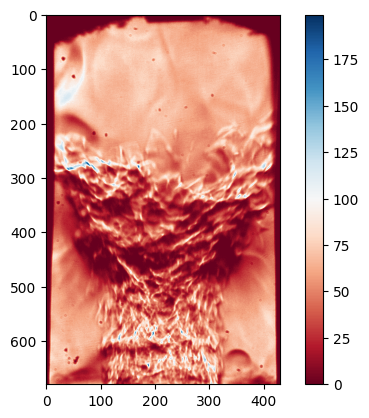

In [10]:
peg = plt.imshow(cropped_data[200], cmap='RdBu')
plt.colorbar(peg)

In [11]:
patches = []
for i in range(data.shape[0]):
    patches.append(patchify.patchify(cropped_data[i], (bin_size, bin_size), bin_size))
patches = np.array(patches)

In [12]:
mean = np.zeros(patches.shape[:3])
# median = np.zeros(patches.shape[:3])
# mode = np.zeros(patches.shape[:3])
for k in range(data.shape[0]):
#     # exec(f'mean_{k} = []')
    for i in range(patches.shape[1]):
        for j in range(patches.shape[2]):
            mean[k][i][j] = np.mean(patches[k][i][j])
            # median[k][i][j] = np.median(patches[k][i][j])
            # mode[k][i][j] = np.mode(patches[k][i][j])

In [13]:
mean_all = np.mean(mean)
print(mean_all)
mean_adj = mean - mean_all

46.88134619892879


In [14]:
from scipy.fft import fft, fftfreq
fft_sig_mean = np.zeros_like(mean).astype(np.complex64)
# fft_sig_median = np.zeros_like(median).astype(np.complex64)
# fft_freq = np.zeros_like(mean).astype(np.complex64)
for i in range(mean.shape[1]):
    for j in range(mean.shape[2]):
            fft_sig_mean[:, i, j] = fft(mean_adj[:, i, j])
            # fft_sig_median[:, i, j] = fft(median[:, i, j])
            # fft_freq[:, i, j] = fftfreq(mean[:, i, j])

In [15]:
n = fft_sig_mean.shape[0] - low_cutoff # Number of data points
frequencies = np.fft.fftfreq(n, d=1/sampling_rate)
frequencies_no_cutoff = np.fft.fftfreq(n+low_cutoff, d= 1/sampling_rate)

In [16]:
fft_ravel = np.reshape(fft_sig_mean, [np.array(cropped_data).shape[0], fft_sig_mean.shape[1]*fft_sig_mean.shape[2]])

In [17]:
fft_filter_1000 = fft_ravel[low_cutoff:]

# for i in range(fft_ravel.shape[1]):
#       for k in range(fft_ravel.shape[0]):
#         if (abs(fft_ravel[k][i]<sampling_rate/2)):
#             fft_filter_1000[k][i] = 0
#         else:
#             fft_filter_1000[k][i] = fft_ravel[k][i]

In [18]:
fft_filter_1000.shape

(796, 3525)

In [19]:
fft_ravel.shape

(806, 3525)

In [20]:
fft_filter_1000.dtype

dtype('complex64')

In [21]:
abs(fft_filter_1000.max())

5322.997

In [22]:
def per_thresh(a, sig):
    new_arr = np.zeros_like(sig)
    top1 = abs(sig.max())
    a1 = 0
    for i,item in enumerate(sig):
        for j,item1 in enumerate(item):
            # print(item)
            if top1*(1-a) < item1:
                a1 = a1+1                                   
                new_arr[i][j] = item1
    print(a1)
    return new_arr


In [23]:
fft_filtered = per_thresh(theshing, fft_filter_1000)

5093


In [24]:
def freq_pre(sig, freq):
    freq_pre = np.zeros_like(sig, dtype=np.float32)
    for i in range(sig.shape[0]):
        for j in range(sig.shape[1]):
            if abs(sig[i][j]) == 0:
                freq_pre[i][j] = 0
            else:
                freq_pre[i][j] = freq[i]
    return freq_pre

In [25]:
freq_pre = freq_pre(fft_filtered, frequencies)

In [26]:
x_data = freq_pre[0:int(freq_pre.shape[0]/2)].astype(np.int32)
y_data = np.absolute(fft_filtered[0:int(freq_pre.shape[0]/2),:]).astype(np.int32)

print(x_data.shape, y_data.shape)

(398, 3525) (398, 3525)


In [27]:
for i in range(x_data.shape[0]):
    for j in range(x_data.shape[1]):
        if x_data[i][j] == 0:
            y_data[i][j] = 0

In [28]:
def arrange(x, y):
    x_data_sort = np.zeros_like(x)
    y_data_sort = np.zeros_like(y)
    for i in range(x.shape[1]):
        idx = np.argsort(y[:,i])
        x_data_sort[:, i] = x[:, i][idx]
        y_data_sort[:, i] = y[:, i][idx]
    return(x_data_sort, y_data_sort)

In [29]:
x_data_sort, y_data_sort = arrange(x_data, y_data)

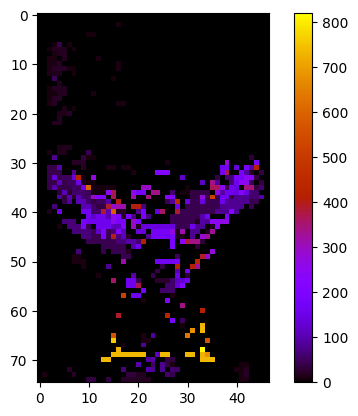

In [30]:
peg = plt.imshow(x_data_sort[-1, :].reshape(fft_sig_mean.shape[1:]), cmap="gnuplot")
plt.colorbar(peg)
# plt.imsave(peg)

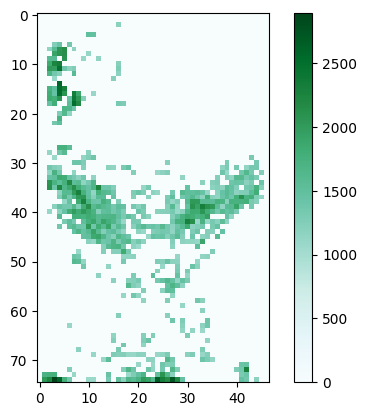

In [31]:
peg = plt.imshow(y_data_sort[-1, :].reshape(fft_sig_mean.shape[1:]), cmap="BuGn")
plt.colorbar(peg)

## Here we have to select the pixel for waveletfromation
#### follwing R - C way, select the row number then followed by the column number 

for example the pixel is at (65, 13)
##### give variable pix_loc = [65, 13]

In [39]:
#Pixel location

pix_loc = [68, 15]

In [40]:
sig = np.array(mean_adj[:, pix_loc[0], pix_loc[1]])

Text(0.5, 0, 'Time (sec)')

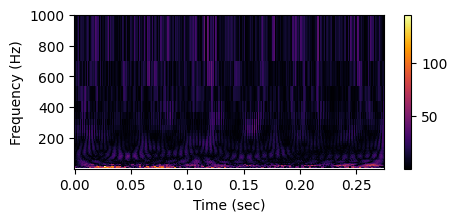

In [41]:
import pywt 



fs = sampling_rate
sampling_period = 1/fs
t = np.linspace(0, mean_adj.shape[0], mean_adj.shape[0])
t = t/fs

wavelet = 'morl'
scale = np.arange(1, 200)


f = pywt.scale2frequency(wavelet, scale)/sampling_period 

coef, freqs = pywt.cwt(sig, scale, wavelet=wavelet,
                       sampling_period=sampling_period)



# Show w.r.t. time and frequency
plt.figure(figsize=(5, 2))
neg = plt.pcolor(t, freqs, abs(coef), cmap='inferno')
plt.colorbar(neg)
# Set yscale, ylim and labels
# plt.yscale('log')
plt.ylim([1, 1000])
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
# plt.savefig('egg_german.png', dpi=150)

#### To see the nth dominant frequency just set the value of dis_nth as the 

for example if you want to 3rd dominant freq
dis_nth = 3

In [35]:
#To see the nth dominant freq

dis_nth  = 2

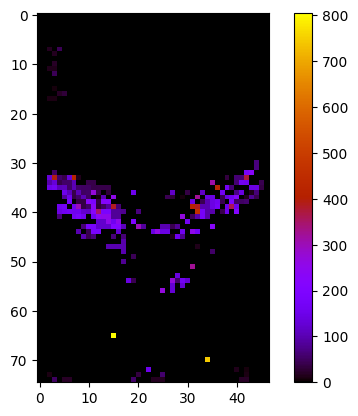

In [36]:
peg = plt.imshow(x_data_sort[-dis_nth, :].reshape(fft_sig_mean.shape[1:]), cmap="gnuplot")
plt.colorbar(peg)
# plt.imsave(peg)

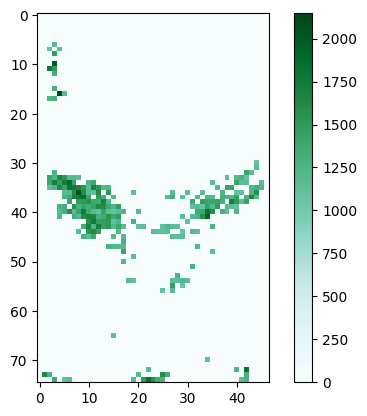

In [37]:
peg = plt.imshow(y_data_sort[-dis_nth, :].reshape(fft_sig_mean.shape[1:]), cmap="BuGn")
plt.colorbar(peg)